In [1]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import math
import librosa
import soundfile as sf
import random

max_duration = 10.0
min_duration = 0.5

In [2]:
'''This Load audio with consistent sample rate,padding and convert stero to mono
   here it would be called once for each audio file you can modify it like you want for multiple files'''

def load_audio(file_path, sample_rate=22050, min_duration=10.0):

    audio, sr = sf.read(file_path)
    
    # if its stero converts to mono
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=1)
    
    # this is to resample 
    if sr != sample_rate:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=sample_rate)
    
    min_samples = int(sample_rate * min_duration)
    # padding audio by tiling if too short 
    if len(audio) < min_samples:
        min_samples = int(sample_rate * min_duration)
        repeats = (min_samples // len(audio)) + 1
        audio = np.tile(audio, repeats)[:min_samples]
    return audio.astype('float32') # choose this coz 32-bit floating point format Compatible with libraries like PyTorch, Librosa, and your model

class MelSpectrogramConverter:

    #to convert Converts audio to Mel-spectrograms 

    def __init__(self, sample_rate=22050, n_mels=128, n_fft=2048, hop_length=209):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.mel_basis = librosa.filters.mel(
            sr=sample_rate,
            n_fft=n_fft,
            n_mels=n_mels,
            fmin=20,
            fmax=sample_rate//2
        )
    
    def __call__(self, audio):
        stft = librosa.stft(
            audio, 
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.n_fft
        )
    
        mel_spec = np.dot(self.mel_basis, np.abs(stft)**2)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        if np.max(mel_spec_db) == np.min(mel_spec_db):
            mel_spec_db = np.full_like(mel_spec_db, 0.0)
        else:
            mel_spec_db = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db))
        return torch.from_numpy(mel_spec_db).float()
    
melspectrogram = MelSpectrogramConverter()

In [3]:
datasetPath = "C:/Users/aniru/Desktop/projects/AudioVision/FSD50K/"

vocab_df = pd.read_csv(datasetPath + 'FSD50K.ground_truth/vocabulary.csv', header=None)
vocab_df.columns = ['index', 'label', 'mid']

vocab_mid = vocab_df['mid'].tolist()
vocab_normal = vocab_df['label'].tolist()
mid_to_index = {row['mid']: row['index'] for _, row in vocab_df.iterrows()}

dev_df = pd.read_csv(datasetPath + 'FSD50K.ground_truth/dev.csv')

num_classes = len(vocab_mid)

In [4]:
train_data_paths = []
train_data_labels = []

num_labels = vocab_df.shape[0]
num_samples = 10

count = 0

for _, row in tqdm(dev_df.iterrows()):
    file_path = os.path.normpath(os.path.join(datasetPath, 'FSD50K.dev_audio', str(row['fname']) + '.wav'))

    if (row['split'] != 'train') or not os.path.exists(file_path):
        continue
    
    with sf.SoundFile(file_path) as f:
      duration_sec = len(f) / f.samplerate
      if (duration_sec > max_duration or duration_sec < min_duration):
         continue
        
    if (count >= 5000):
       break

    labels = row['mids'].split(',')
    label_indices = [mid_to_index[label] for label in labels if label in mid_to_index]
    label = torch.zeros(num_classes, dtype=torch.float32)
    label[label_indices] = 1
    
    train_data_paths.append(file_path)
    train_data_labels.append(label)
    count += 1

# train_data_paths remains a list of strings (file paths)
train_data_labels = torch.stack(train_data_labels)

print(f"Number of labels: {num_labels}")
print(f"Number of training samples: {len(train_data_paths)}")

0it [00:00, ?it/s]

Number of labels: 200
Number of training samples: 5000


In [5]:
max_images = 5000
shard_size = 500
n_processed_examples = 0
n_processed_shards = 0
rel_idxs = []
max_images = min(max_images, len(train_data_paths))
num_shards = (max_images + shard_size - 1) // shard_size
pad_size = math.log10(num_shards) + 1


print(max_images)

5000


In [6]:
selected_indices = random.sample(range(len(train_data_paths)), max_images)
train_data_paths = [train_data_paths[i] for i in selected_indices]
train_data_labels = train_data_labels[selected_indices]

In [7]:
# Given a shard, it returns 2 tensors, one for image and another for the label vector which it also creates 
def process_files(shard_data_paths, shard_data_labels):
  img_tensor = []
  lbls_tensor = []
  
  for i in range(len(shard_data_paths)):
    audio = load_audio(shard_data_paths[i])
    mel_spec = melspectrogram(audio)
    img_tensor.append(mel_spec)
    lbls_tensor.append(shard_data_labels[i])

  img_tensor = torch.stack(img_tensor)
  lbls_tensor = torch.stack(lbls_tensor)

  class_idxs = [torch.where(lbls_tensor[:, c] == 1)[0] for c in range(num_classes)]
  
  return img_tensor, lbls_tensor, class_idxs

In [8]:
def pad_num(n, width):
  return str(n).zfill(width)

In [9]:
def save_chunk(imgs, lbls, idx):
  shard_data = {"imgs": imgs, "lbls": lbls}
  padded_num = pad_num(idx, int(pad_size))
  torch.save(shard_data, os.path.join(".", "data", "new_processed", f"fsd_{padded_num}.pth"))

In [10]:
acc_shard_class_idxs = []
class_idxs = []

print(f"Processing {max_images} files")
for shard_idx in tqdm(range(0, max_images, shard_size), desc="Processing chunks"):
  shard_data_paths = train_data_paths[shard_idx: min(shard_idx + shard_size, max_images)]
  shard_data_labels = train_data_labels[shard_idx: min(shard_idx + shard_size, max_images)]
  imgs, lbls, shard_class_idxs = process_files(shard_data_paths, shard_data_labels)
  save_chunk(imgs, lbls, n_processed_shards)
  acc_shard_class_idxs.append(shard_class_idxs) # store a list of precalculated indices which are part of each class
  
  n_processed_shards += 1 # for shard naming scheme
  
  n_processed_examples += len(imgs) # update total examples for tracking in rel_idxs
  rel_idxs.append(n_processed_examples - 1)  # store index of the latest example of this chunk so we can identify which chunk an index is from
  
class_idxs = [torch.cat(shard_class_idxs) for shard_class_idxs in zip(*acc_shard_class_idxs)]
torch.save({
  'rel_idxs': rel_idxs,
  'class_idxs': class_idxs
}, os.path.join(".", "data", "new_processed", f"fsd_meta.pth"))

Processing 5000 files


Processing chunks:   0%|          | 0/10 [00:00<?, ?it/s]

Rough testing code

In [11]:
test_data = torch.load(os.path.join(".", "data", "new_processed", f"fsd_00.pth"))

C:\Users\aniru\AppData\Local\Temp\ipykernel_33492\3209812261.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(".", "data", "new_proces

In [14]:
print(test_data['imgs'][0].shape)
img_np = test_data['imgs'][0].unsqueeze(0).permute(1, 2, 0).numpy()

torch.Size([128, 1056])


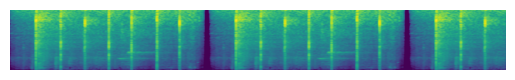

In [15]:
import matplotlib.pyplot as plt

# Display
plt.imshow(img_np)
plt.axis('off')
plt.show()